# CSII 2023 Exercise 04: State Feedback with Luenberger Observer

Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

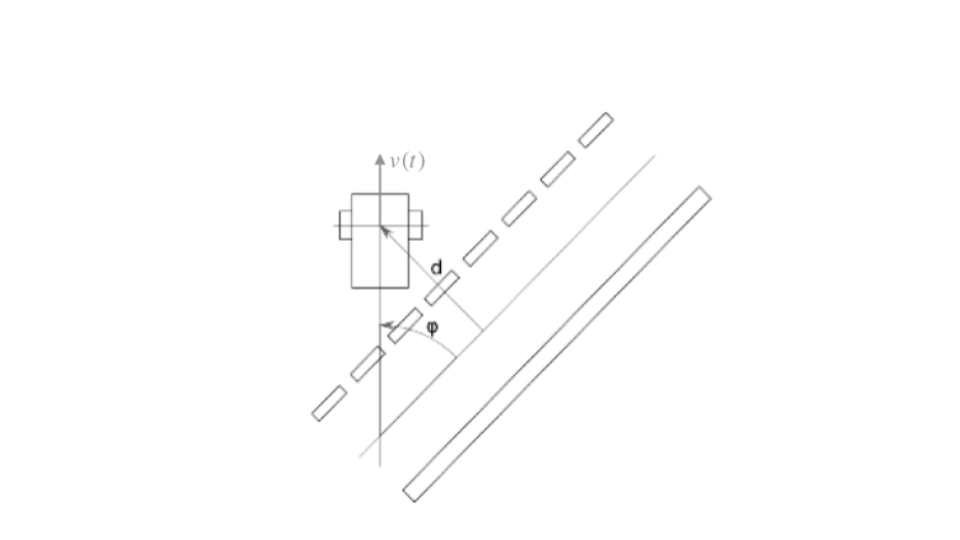

-------
## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.





In [ ]:
# Install the required python library with pip
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [ ]:
# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [ ]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [ ]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: np.array,
               w_curvy: np.array,
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)



    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()


def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: List[np.array],
               w_curvy: np.array,
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(t)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        legend_list.append(f'controller_{i}')

    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)



    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t[0], y_coord_ref)
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(t[i], y_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t[0], w_curvy)
    for i in range(number_ctr):
        plt.plot(t[i], w_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array,
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    # plt.plot(t, x[3])
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    # plt.plot(t, u_ofb[0])
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')

## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library.

In [ ]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

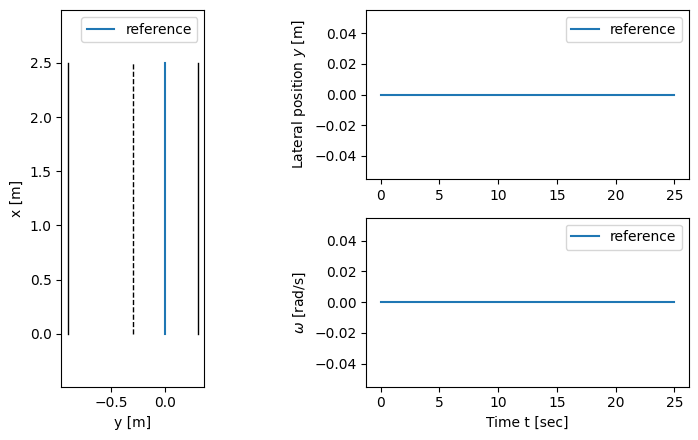

In [ ]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [ ]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



-----------------

## Pole Placement

This is the pole placement function from last exercise. This time we only use the `control` library.

In [ ]:
def feedforward_kr_solution(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr

def place_poles_Ackermann(A: np.array, B: np.array, C: np.array,
                          D: float, poles: List):
    K = ct.acker(A,B,poles)
    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)

    kr = feedforward_kr_solution(A, B, C, K)

    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return K, kr, clsys

## Noise

In this section we will do the same as in the last coding exercise, but this time with noise. Choose the noise type which you would like to test in `index_noise`, where you change the integer number to the noise index you want test. Index `index_noise = 0` corresponds to a constant noise (i.e. constant shift of the states), index `index_noise = 1` is a random uniform noise, `index_noise = 2` is white noise and `index_noise = 3` no noise.

In [ ]:
noise_type = ['const', 'uniform', 'white_noise', 'no_noise']
index_noise = 3
noise = noise_type[index_noise]
if noise == 'const':
    n = np.ones(r.shape)*0.5
elif noise=='uniform':
    n = np.random.uniform(low=-0.1, high=0.1, size=r.shape)
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))

## Exercise 1: Observability

Write code to check if the linearized and normalized system is observable. Use only the numpy library.

NumPy Hints:

    matrix multiplication: Z = X @ Y
    rank of a matrix: r = np.linalg.matrix_rank(X)
    concatination of matrices along column axis: XY = np.concatenate((X, Y), axis=1)


In [ ]:
# Write here the reachability test

## Solution Exercise 1: Observability

In [ ]:
#@title
CA = C @ A
O = np.concatenate((C, CA), axis=0)
rr = np.linalg.matrix_rank(O)

if rr < 2:
  print(f'The system is not observable because the rank of O is: {rr}.')
else:
  print(f'The system is observable because rank of O is: {rr}.')


The system is observable because rank of O is: 2.


## Exercise 2: Ackermann's formula Estimator

As last time, we want to use Ackermann's formula to get our closed loop gain for the estimator. Try to implement your own version using the A and C matrices and a list of poles you want. Try to use only the numpy library.

NumPy Hints:

    matrix inverse: np.linalg.inv(X)
    2x2 identity matrix: np.identity(2)


In [ ]:
def acker_estimator(A: np.array, C: np.array, poles: List[float]) -> np.array:
    # TODO: write code
    L = np.array([[1], [1]])

    return L

### Solution Exercise 2: Ackermann's formula Estimator

In [ ]:
#@title
def acker_estimator_solution(A: np.array, C: np.array, poles: List[float]) -> np.array:
    CA = C @ A
    O = np.concatenate((C, CA), axis=0)
    O_inv = np.linalg.inv(O)
    gamma = O_inv @ np.array([[0, 1]]).T

    p_1 = poles[0]*(-1)
    p_2 = poles[1]*(-1)
    ab = p_1 + p_2
    b = p_1*p_2
    p_cl = A @ A + ab*A + b*np.identity(2)

    L = p_cl @ gamma

    return L

Test your implementation here.

In [ ]:
poles = [-1, -2]

L_test = acker_estimator(A, C, poles)
L_sol = acker_estimator_solution(A, C, poles)

print(f'Your implementation: {L_test}')
print(f'Solution: {L_sol}')

Your implementation: [[1]
 [1]]
Solution: [[ 3.]
 [20.]]


##Exercise 3: Duality of estimation and control

We have learned about the duality of estimation and control. We don't want to have seperate Ackermann's formula implementations for the both problems. We want to use one implementation. How would you use the `acker` function from the `control` library for calculating the gain of the estimator? Instead of using the `control` library you could also use your implementation from the state feedback exercise.

In [ ]:
# Use poles_test to test your implemnation against the solution
poles_test = [-2, -3]

In [ ]:
# Write your code here. Something like:
# L = ct.acker(matrix, matrix, poles_test)
L_dual = np.array([[1], [1]])

## Solution Exercise 3: Duality of estimation and control

In [ ]:
#@title
L_sol_dual = ct.acker(A.T, C.T, poles_test).T

Test your implementation here:

In [ ]:
print(f'Your implementation: {L_dual}')
print(f'Solution: {L_sol_dual}')

Your implementation: [[1]
 [1]]
Solution: [[ 5.]
 [60.]]


## Simulation
In the next cell we code the whole state feedback control loop as an input output system. Take a look and try to understand the code.

In [ ]:
def state_noise(u: np.array) -> np.array:
    y = u[1] + u[0]
    theta = u[2] + u[0]
    return np.array([y, theta])

def state_feedback_controller(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return u

def plant(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    xdot = A @ x + B @ u
    return xdot

def plant_out(x: np.array, u: np.array) -> np.array:
    y = x
    return y

def estimator(x: np.array, u: np.array, A: np.array, B: np.array,
        C: np.array, D: np.array, L: np.array) -> np.array:
  x = np.expand_dims(x, axis=1)
  xdot = (A - L @ C) @ x + B * u[0]  + L*u[1]
  return xdot


def estimator_out(x: np.array, u: np.array) -> np.array:
    return x

def get_closed_loop_io_system(io_system_params: dict) -> ct.NonlinearIOSystem:
  sys_n = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_noise(u),
      inputs=('n', 'y', 'theta'),
      outputs=('yn', 'thetan'),
      params=None,
      name='noise')

  sys_cont = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2'),
      outputs=('control'),
      params=io_system_params,
      name='controller')


  sys_est = ct.NonlinearIOSystem(
    lambda t, x, u, params: estimator(x, u, params['A'], params['B'],
                                      params['C'], params['D'], params['L']),
    lambda t, x, u, params: estimator_out(x, u),
    inputs=('control', 'y', 'theta'),
    outputs=('y', 'theta'),
      states=('x1', 'x2'),
    params=io_system_params,
    name='estimator')

  sys_dyn = ct.NonlinearIOSystem(
      lambda t, x, u, params: plant(x, u, params['A'], params['B']),
      lambda t, x, u, params: plant_out(x, u),
      inputs=('control',),
      outputs=('y', 'theta'),
      states=('x1', 'x2'),
      params=io_system_params,
      name='plant')


  io_closed = ct.interconnect(
    [sys_dyn, sys_cont, sys_n, sys_est],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['controller.x1', 'estimator.y'],
      ['controller.x2', 'estimator.theta'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y'],
      ['estimator.control', 'controller.control'],
      ['estimator.y', 'noise.yn'],
      ['estimator.theta', 'noise.thetan']
    ],
    inplist=['controller.reference', 'noise.n'],
    outlist=['plant.y', 'controller.control']
  )

  return io_closed

def simulate(A: np.array, B: np.array, C: np.array,
            t: np.array, U: np.array, X0: List,
            poles: List, poles_observer: List) -> Tuple[np.array, np.array]:
            K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                            poles=poles)
            L = ct.acker(A.T, C.T, poles_observer).T
            io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr, 'L': L}
            io_closed = get_closed_loop_io_system(io_system_params)

            tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

            return tp, yp


Now we would like to simulate the system with a state feedback controller and a Luenberger observer. In the next cell you can choose your controller poles in `poles_controller`, your observer poles in `poles_observer` and your initial state `x0`. The first two elements of `x0` are the `y` and `theta` initial states of the plant (true initial state) and the last two elments are the `y` and `theta` initial states of the estimator. Try to change the initial guess of your estimator and choose the right relative poles between controller and observer (rule of thumb from class).

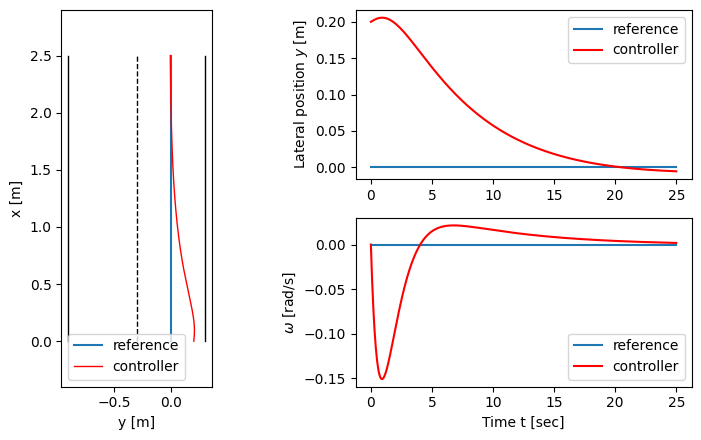

In [ ]:
poles_controller = [-0.1, -0.1]
poles_observer = [-1, -1]
x0 = [0.2, 0.1, 0.0, 0.0]
tp, yp = simulate(A, B, C, t, U, x0, poles_controller, poles_observer)
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy,
            yp[0], yp[1])

## Poles Comparison

In this section we will do the same as before, just comparing different poles against each other. We will compare aggressive poles, less aggressive poles and complex conjugate poles for the observer. We will keep the controller poles constant.

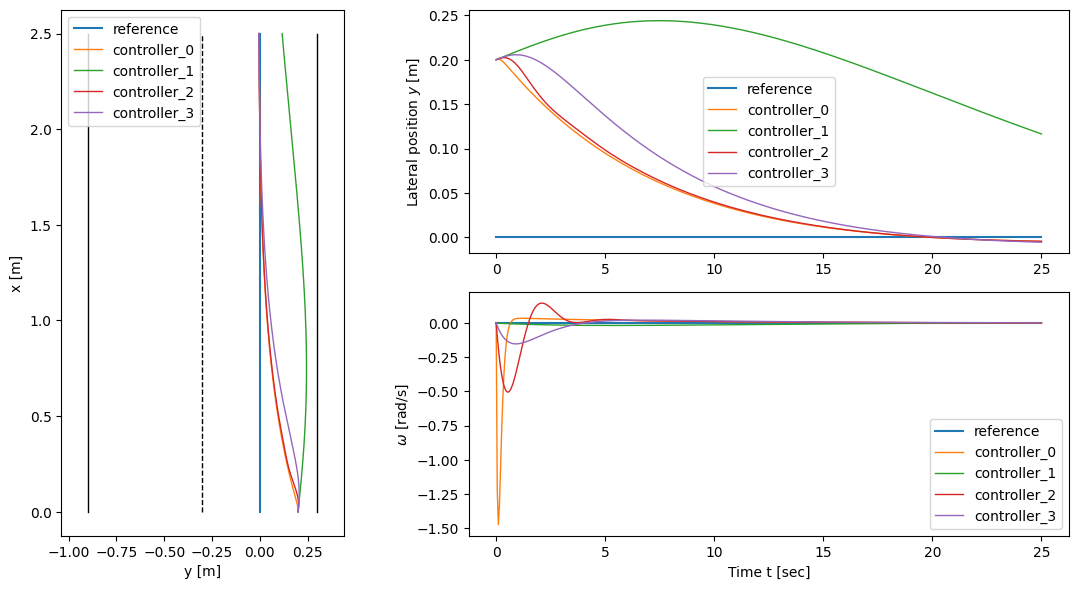

In [ ]:
poles_controller = [-0.1, -0.1]
poles_aggressive = [-10, -10]
poles_easy = [-0.1, -0.1,]
poles_complex_1 = [-1+2j, -1-2j]
poles_complex_2 = [-1+0.1j, -1-0.1j]
x0 = [0.2, 0.1, 0.0, 0.0]

pole_list = [poles_aggressive, poles_easy, poles_complex_1, poles_complex_2]
t_list = []
y_list = []
u_list = []
for p in pole_list:
  tp, yp = simulate(A, B, C, t, U, x0, poles_controller, p)
  t_list.append(tp)
  y_list.append(yp[0])
  u_list.append(yp[1])

plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)


## Initial state comparison

In this section we will do the same as before, just comparing different initial states . We will keept the poles and the initial guess of the estimator constant but change the initial position of the duckiebot.

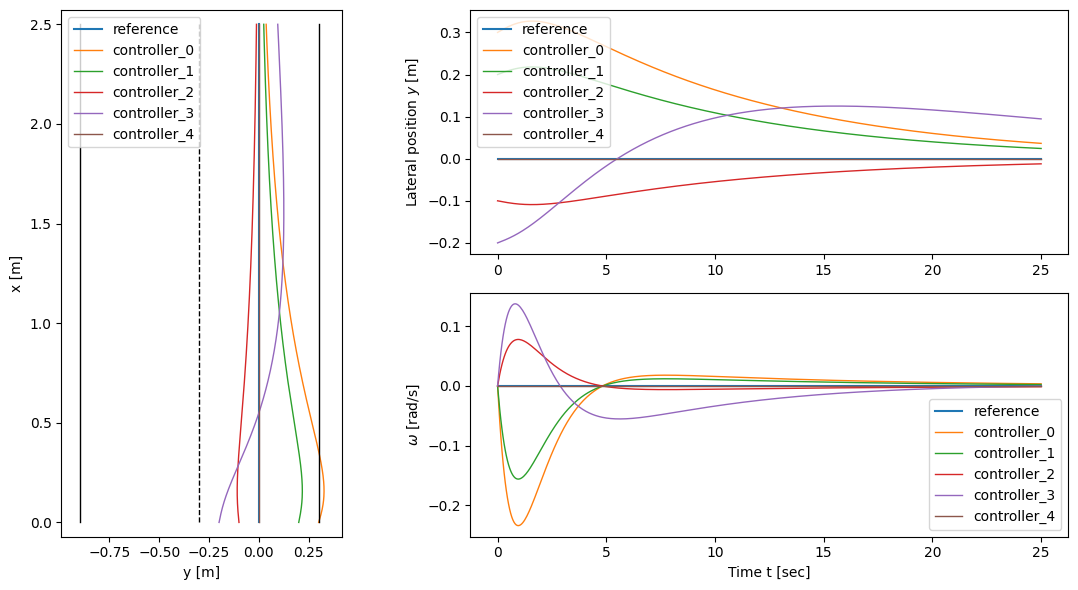

In [ ]:
poles_controller = [-0.1, -0.1]
poles_observer = [-1, -1]

x01 = [0.3, 0.3, 0.0, 0.0]
x02 = [0.2, 0.2, 0.0, 0.0]
x03 = [-0.1, -0.1, 0.0, 0.0]
x04 = [-0.2, 0.2, 0.0, 0.0]
x05 = [0.0, 0.0, 0.0, 0.0]

x0_list = [x01, x02, x03, x04, x05]
t_list = []
y_list = []
u_list = []
for x0 in x0_list:
  tp, yp = simulate(A, B, C, t, U, x0, poles_controller, poles_observer)
  t_list.append(tp)
  y_list.append(yp[0])
  u_list.append(yp[1])

plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)


## Outlook
- Change the tracks and create your own reference track
- Use different poles and check how the controller performance changes
- Change the the noise type
- Change the initial conditions `x0`
- Ask ChatGPT for solutions and compare them with your own :)